importation des bibliothèques

In [99]:
import numpy as np
import matplotlib.pyplot as plt

variables globales

In [100]:
df = 5000 #excursion de fréquence
fm = 25 #fréquence de modulation
Fm = 40000 #fréquence de la porteuse
c = 340 #célérité du son dans l'air
Ti = 0.0
Tf = 0.1
p = 10**(-7)
t = np.arange(Ti, Tf, p) #paramétrage de l'intervalle de temps
n = len(t)
E = 5
f = 100
v = 2 #vitesse de l'obstacle
fd = 2*v/c*Fm #décalage Doppler
k = 1/10
d = 0.3 #distance de l'obstacle

contruction signal triangulaire


In [101]:
def triangle (t, A, f):
  '''entrée : temps, amplitude, fréquence
     sortie : signal triangulaire correspondant aux paramètres'''
  T = 1/f
  s = np.zeros(n)
  s[0] = -A
  for i in range (n-1):
    d = t[i]/T - int(t[i]/T)
    if 0 <= d < 1/2:
      s[i+1] = s[i] + 4*(A/T)*p
    else:
      s[i+1] = s[i] - 4*(A/T)*p
  return s


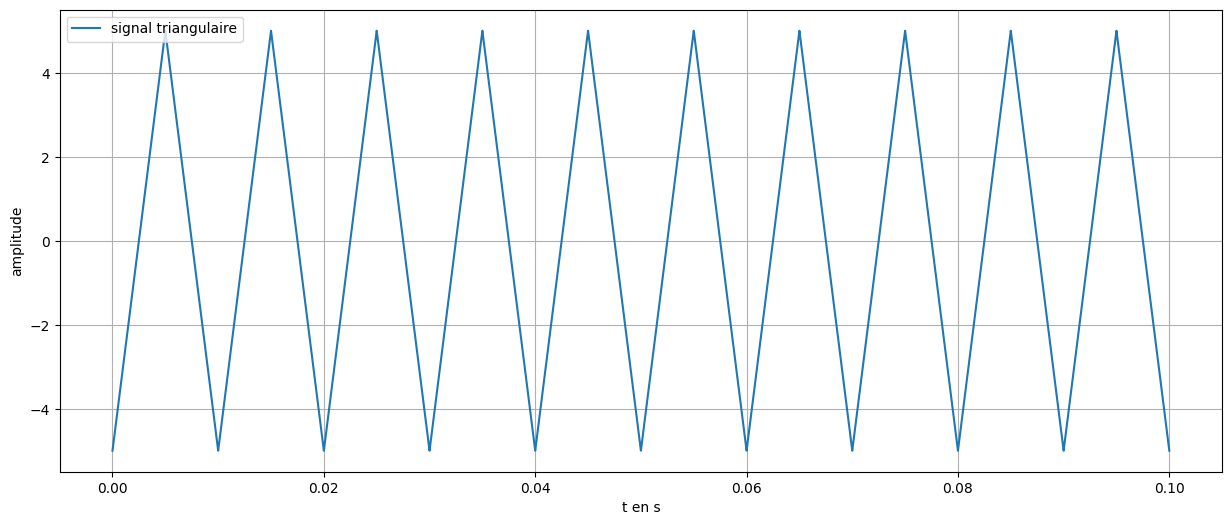

In [108]:
plt.close()
plt.figure(1,figsize = [15,6])
plt.plot(t, triangle(t, E, f),label = 'signal triangulaire')
plt.xlabel('t en s')
plt.ylabel('amplitude')
plt.grid()
plt.legend()
plt.show()

fréquence modulée
*   df = excursion de fréquence
*   fm = fréquence de modulation
*   Fm = fréquence de la porteuse (Fm > fm)

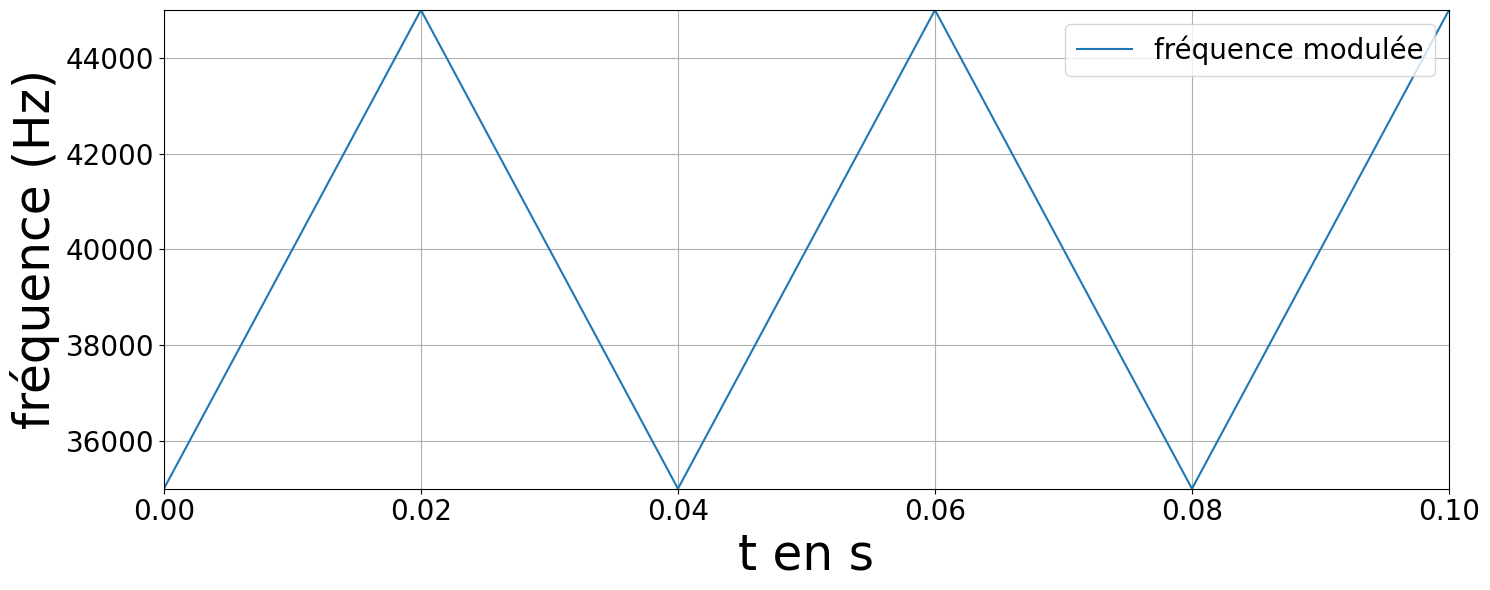

In [93]:
def fmod (df, fm, Fm, t):
  '''illustre la variation de fréquence imposée par la modulante'''
  return Fm + df * triangle(t, 1, fm)


plt.close()
plt.figure(2,figsize = [15,6])
plt.plot(t, fmod(df,fm,Fm,t), label = 'fréquence modulée')
plt.legend(fontsize='20')
plt.ylim(35000,45000)
plt.xlim(0,0.1)
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.grid()
plt.xlabel('t en s',fontsize= '35')
plt.ylabel('fréquence (Hz)', fontsize= '35')
plt.show()

signal modulé en fréquence
* on prend une fréquence de 1kHz pour une meilleure visibilité

/tmp/ipython-input-80-2939928434.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize = '20')


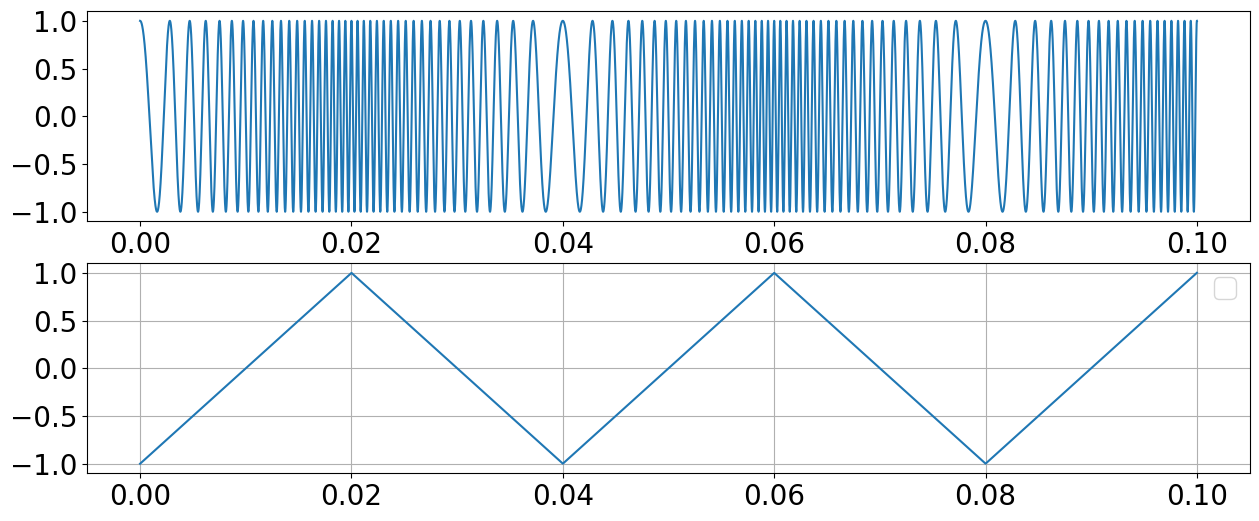

In [80]:
def smod(t, A, fm, df, Fm):
  '''renvoie un signal modulé en fréquence par un triangle'''
  phi = np.zeros(n)
  phi[0] = 0
  f = fmod(df, fm, Fm, t)
  for i in range(n-1):
    phi[i+1] = phi[i] + 2*np.pi*p*f[i]
  return A*np.cos(phi)

ftest = 1000
dftest = 750
fmtest = 25

plt.close()
plt.figure(3, figsize=[15,6])
plt.subplot(2,1,1)
plt.plot(t, smod(t, E, fmtest, dftest, ftest)/E)
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.subplot(2,1,2)
plt.plot(t, (fmod(dftest,fmtest,ftest,t)-ftest)/750)
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')

plt.grid()
plt.legend(fontsize = '20')
plt.show()

contruction filtre passe bande d ordre 2 de l'émetteur

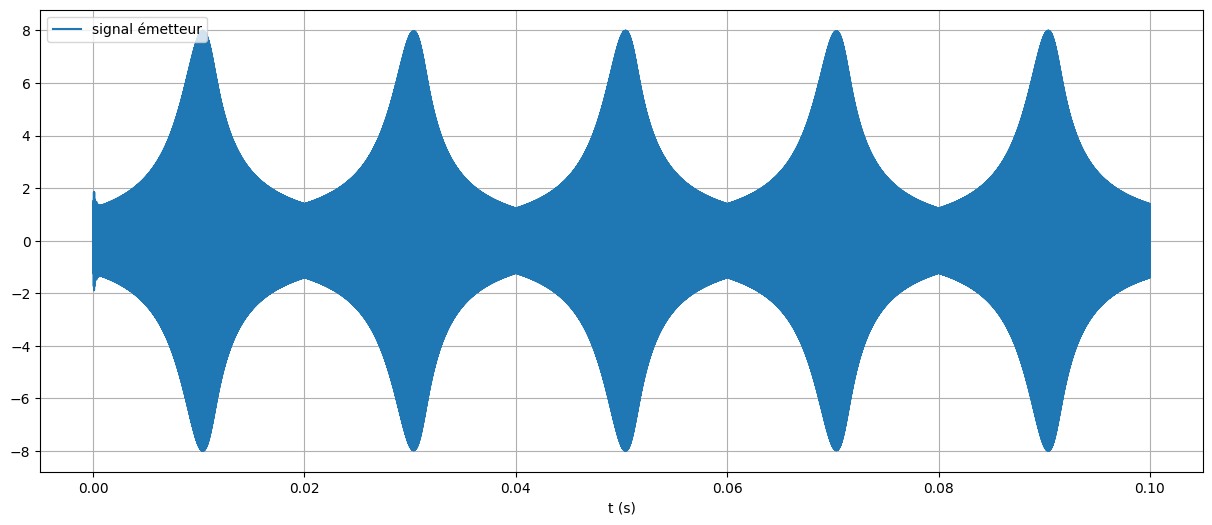

In [81]:
from scipy.integrate import odeint

def filtre(e):
  '''simulation d'un passe bande'''
  f0 = 40000
  w0 = 2*np.pi*f0
  Q = 15

  s = np.zeros(n)
  s[0] = 0
  s[1] = 0
  for k in range(n-2):
    s[k+2] = 2*s[k+1]-s[k] +(((e[k+1]-e[k])/p)*w0/Q -w0/Q*(s[k+1]-s[k])/p - w0**2*s[k])*p**2
  return s



def semet(t, A, fm, df, Fm):
  return filtre(smod(t, A, fm, df, Fm))

plt.close()
plt.figure(4, figsize=[15,6])
plt.plot(t, semet(t, E, fm, df, Fm), label = 'signal émetteur')
plt.xlabel('t (s)')
plt.legend()
plt.grid()
plt.show()

simulation d'un décalage temporel dû au temps de propagation

In [82]:
tau = 2*d/c #décalage temporel dû à la propagation

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


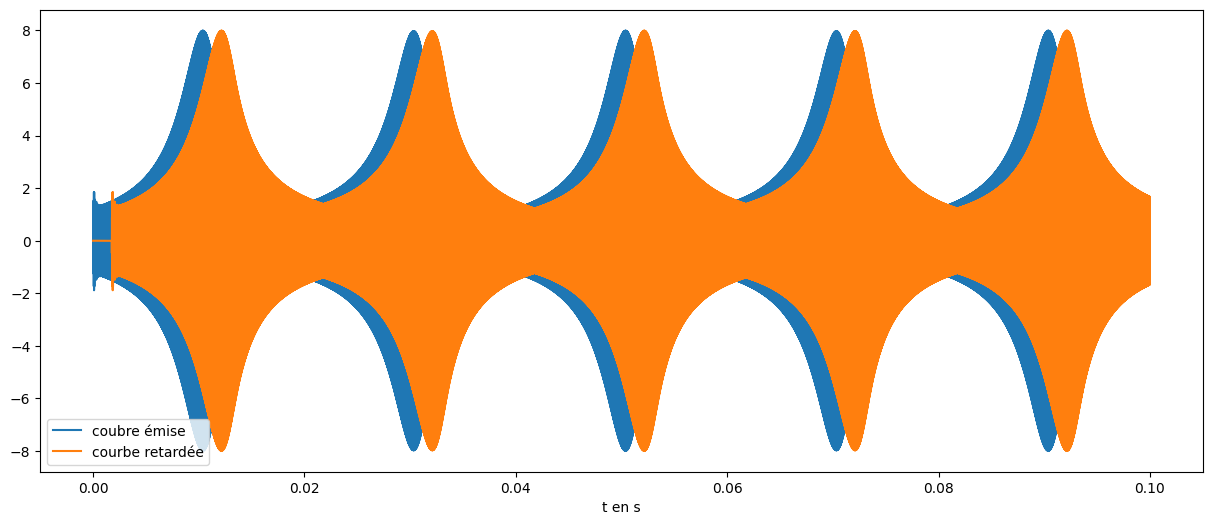

In [83]:
def retard(t, tau, semet):
  ktau=int(tau/p)
  erecep =np.zeros(n)
  for k in range(ktau):
      erecep[k] =0
  for k in range(ktau+1, n) :
      erecep[k]=semet[k-ktau]
  return erecep

plt.close()
plt.figure(5, figsize= [15,6])
plt.plot(t, semet(t, E, fm, df, Fm), label= 'coubre émise')
plt.plot(t, retard(t, tau, semet(t, E, fm, df, Fm)), label= 'courbe retardée')
plt.xlabel('t en s')
plt.legend()
plt.show()

passage du signal dans le récepteur (2ème passe bande)

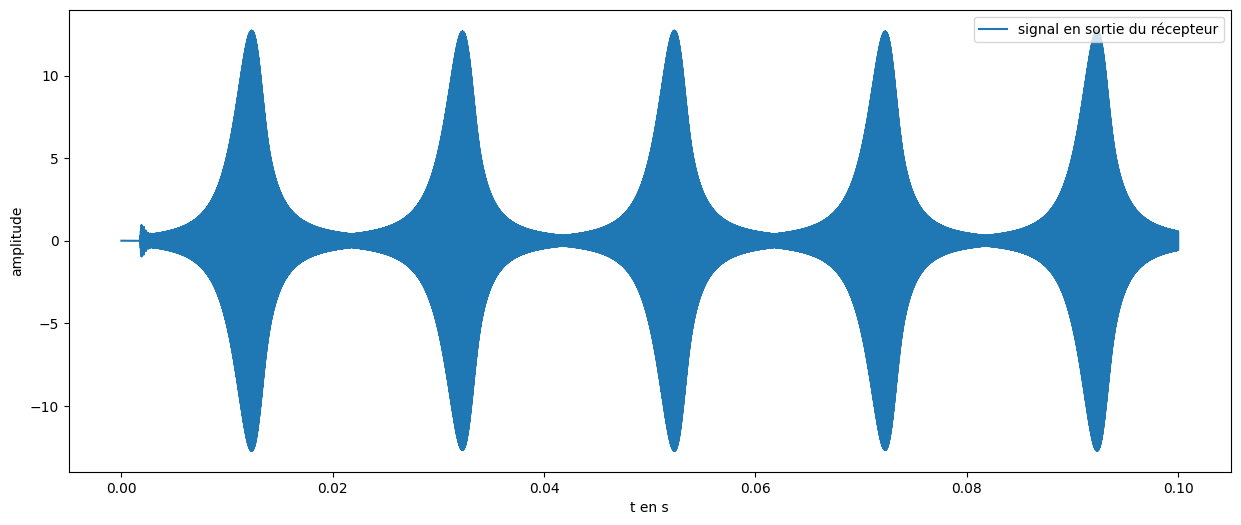

In [84]:
def sR(t,A, Fm,df,fm ,tau ) :
    return filtre(retard(t,tau,semet(t, A, fm, df, Fm)))

plt.close()
plt.figure(6, figsize= [15,6])
plt.plot(t, sR(t, E, Fm, df, fm, tau), label= 'signal en sortie du récepteur')
plt.xlabel('t en s')
plt.ylabel('amplitude')
plt.legend()
plt.show()

signal en sortie du multiplieur

In [85]:
def mult(t, tau, Fm, A, fm, df, fd, k):
  return smod(t, A, fm, df, Fm)*sR(t, A, Fm-fd, df, fm, tau)*k


contruction graphique

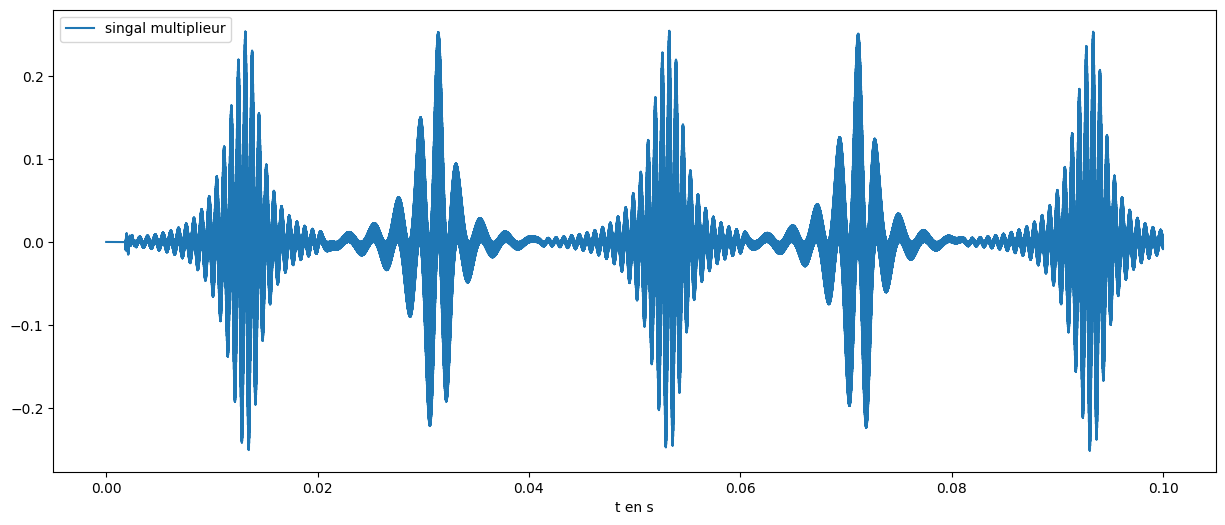

In [86]:
plt.close()
plt.figure(7, figsize= [15,6])
plt.plot(t, mult(t, tau, Fm, 1, fm, df, fd, k), label= 'singal multiplieur')
plt.xlabel('t en s')
plt.legend()
plt.show()

filtre passe bas


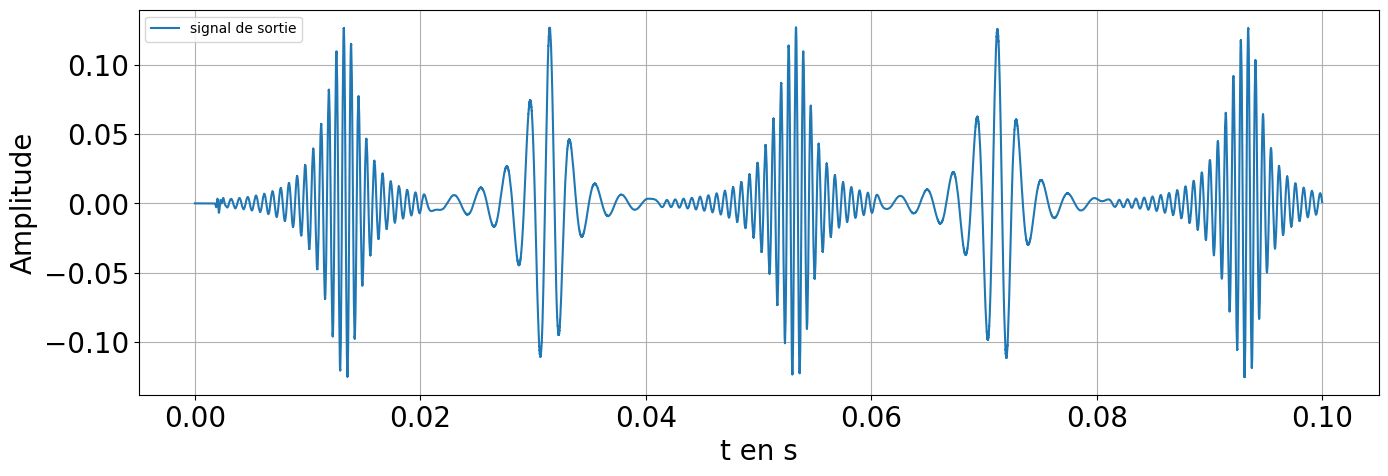

In [87]:
  def bas(e,fb) :
    '''simulation du passe bas'''
    Qb = 0.71
    omega_b=2*np.pi*fb
    s=np.zeros(n)
    s[0]=0
    s[1]=0
    for k in range(0, n-2):
        s[k+2]=2*s[k+1]-s[k] +(omega_b**2*e[k] -omega_b/Qb*(s[k+1]-s[k])/p -omega_b**2*s[k])*p**2
    return s

E = 1
Fm = 40000  # Porteuse en Hz
df = 5000  # Excursion en Hz
fm = 25  # Fréquence de modulation en Hz
d = 0.3 # Distance en m de la cible
tau = 2*d/c # Retard dû à la propagation
fb = 5000  # Permet d'éliminer 2*Fm

s = bas(mult(t, tau, Fm, E, fm, df, fd, k), fb)

plt.close()
plt.figure(7, figsize= [16,5])
plt.plot(t,s,label= 'signal de sortie')
plt.grid()
plt.legend()
plt.ylabel('Amplitude',fontsize='20')
plt.xlabel('t en s',fontsize='20')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.show()

TRACER DE LA FREQUENCE EN FONCTION DU TEMPS

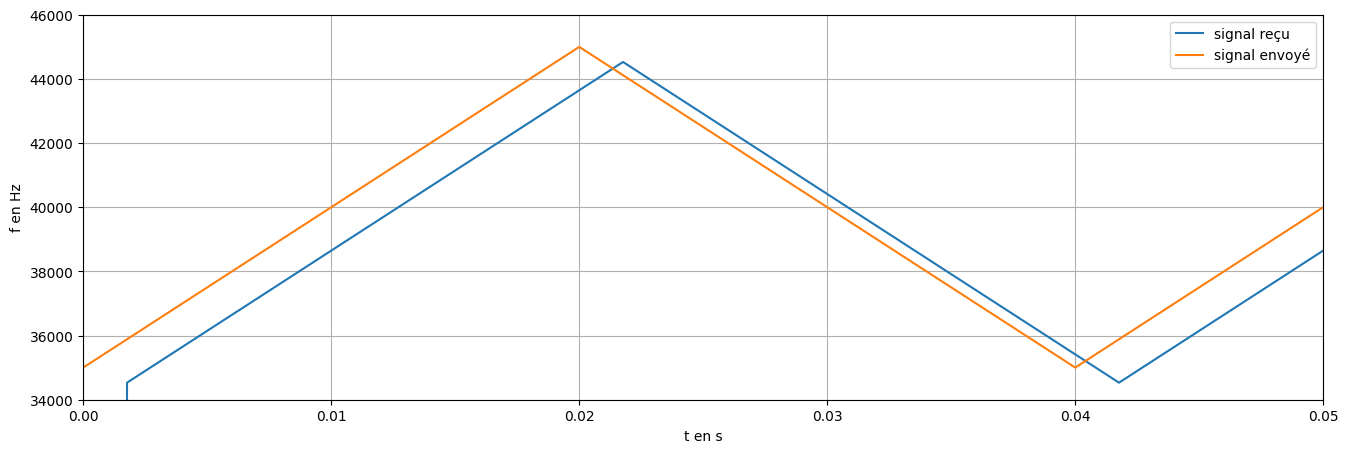

In [88]:
def FMCW(t, fm, df, Fm, tau, fd):
  '''visualisation de l'évolution de la fréquence du signal'''
  return retard(t, tau, fmod(df, fm, Fm-fd, t))


plt.close()
plt.figure(8, figsize= [16,5])
plt.plot(t, FMCW(t, fm, df, Fm, tau, fd), label= 'signal reçu')
plt.plot(t, fmod(df, fm, Fm, t), label= 'signal envoyé')
plt.xlim(Ti, 0.05)
plt.ylim(34000, 46000)
plt.grid()
plt.legend()
plt.xlabel('t en s')
plt.ylabel('f en Hz')
plt.show()


TRACER DE LA CARRACTERRISTIQUE DE L'EMETTEUR A L'HORIZONTALE

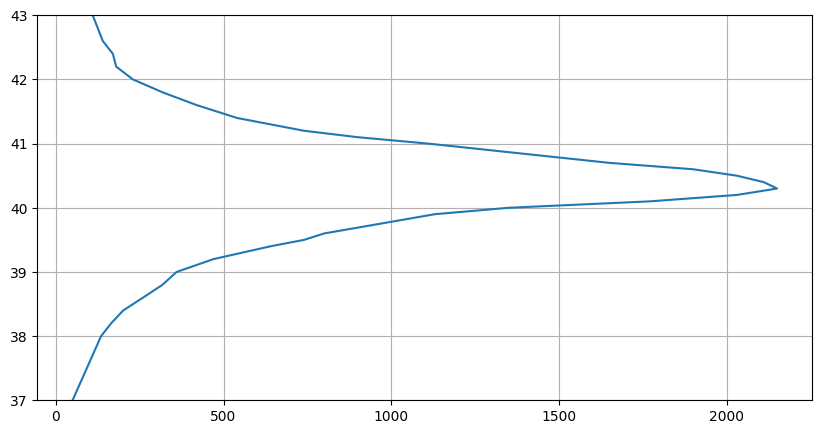

In [89]:
freq = [37, 38, 38.2, 38.4, 38.6, 38.8, 39, 39.2, 39.4, 39.5, 39.6, 39.7, 39.8, 39.9, 40, 40.1, 40.2, 40.3, 40.4, 40.5, 40.6, 40.7, 40.8, 40.9, 41, 41.1, 41.2, 41.4, 41.6, 41.8, 42, 42.2, 42.4, 42.6, 43]
ampl = [50, 135, 165, 201, 260, 318, 360, 470, 640, 740, 800, 910, 1020, 1130, 1350, 1770, 2030, 2150, 2110, 2030, 1900, 1650, 1470, 1290, 1110, 900, 740, 540, 420, 318, 230, 180, 170, 140, 110]

plt.close()
plt.figure(9, figsize= [10,5])
plt.plot(ampl,freq)
plt.ylim(37,43)
plt.grid()
plt.show()


MESURES DE DISTANCES

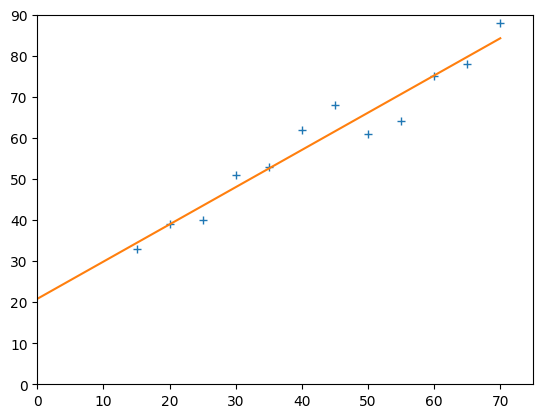

20.815850815850823


In [90]:
dmes = [33, 39, 40, 51, 53, 62, 68, 61, 64, 75, 78, 88]
'''distances mesurées'''
dth = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
'''distances théoriques'''
lin = np.polyfit(dth,dmes,1)
x = np.linspace(0, 70, 100)
y = lin[0]*x + lin[1]

plt.close()
plt.plot(dth,dmes, '+')
plt.plot(x, y)
plt.xlim(0,75)
plt.ylim(0,90)
plt.show()
print(lin[1])

INCERTITUDES SUR LA DISTANCE

[5.88763009 5.89312917 5.89097435 5.89317193 5.8888601  5.88895579
 5.88578366 5.88765191 5.88425952 5.8874711  5.88875893 5.88935392]


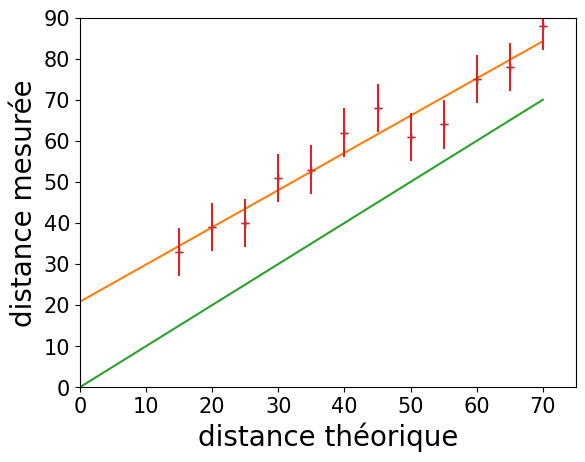

In [91]:
fexp = [78, 92, 94, 121, 125, 147, 166, 145, 151, 178, 185, 208]

f=[[],[],[],[],[],[],[],[],[],[],[],[]]
N= 1000
for j in range (len(fexp)):
  for i in range (N):
    f[j].append(fexp[j] + np.random.uniform(-24,24,N))

derr = np.zeros(12)
for i in range (len(fexp)):
  derr[i]  = (340*np.std(f[i],ddof = 1))/(2*10000*4)*100
print(derr)

plt.close()
plt.plot(dth,dmes,'+')
plt.plot(x,y)
plt.plot(x,x)
plt.errorbar(dth, dmes, yerr=derr, fmt = '+')
plt.xlim(0,75)
plt.ylim(0,90)
plt.xlabel('distance théorique',fontsize='20')
plt.ylabel('distance mesurée',fontsize='20')
plt.xticks(fontsize='15')
plt.yticks(fontsize='15')
plt.show()

INCERTITUDES SUR LA VITESSE


In [92]:
f1exp = 119
f2exp = 131

N= 10000

f1 =f1exp + np.random.uniform(-5,5,N)
f2 =f2exp + np.random.uniform(-5,5,N)

fdop=abs(f1-f2)/2

v = (340*fdop)/(2*40000)*1000

print('moyenne de v =',np.mean(v) )
print('écart-type de v =', np.std(v, ddof = 1))

moyenne de v = 25.47630385207656
écart-type de v = 8.589092241738383
